# Rotten Tomato Reviews
### Oliver Northing, Ryan Huang, Maria Zhang

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from wordcloud import WordCloud
from tqdm.auto import tqdm
from torch.nn.utils.rnn import pad_sequence

import sys
sys.modules['datasets'] = None
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification


import warnings
warnings.filterwarnings("ignore")

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## Load Dataset

In [2]:
df = pd.read_csv("data_rt.csv")

print("First 5 rows:")
display(df.head())

print("\nColumn names:")
print(df.columns)

print("\nMissing values:")
print(df.isna().sum())

print("\nReview length stats:")
print(df['reviews'].str.len().describe())

# Class distribution
df['labels'].value_counts(normalize=True)


First 5 rows:


,reviews,labels
0,"simplistic , silly and tedious .",0
1,"it's so laddish and juvenile , only teenage bo...",0
2,exploitative and largely devoid of the depth o...,0
3,[garbus] discards the potential for pathologic...,0
4,a visually flashy but narratively opaque and e...,0



Column names:
Index(['reviews', 'labels'], dtype='object')

Missing values:
reviews    0
labels     0
dtype: int64

Review length stats:
count    10662.000000
mean       115.156256
std         51.199546
min          5.000000
25%         77.000000
50%        112.000000
75%        150.000000
max        269.000000
Name: reviews, dtype: float64


labels
0    0.5
1    0.5
Name: proportion, dtype: float64

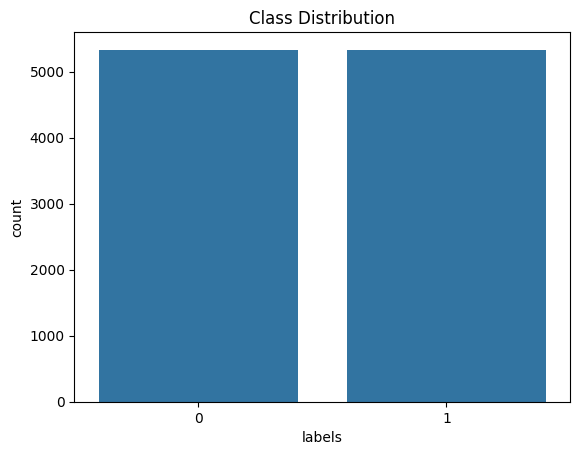

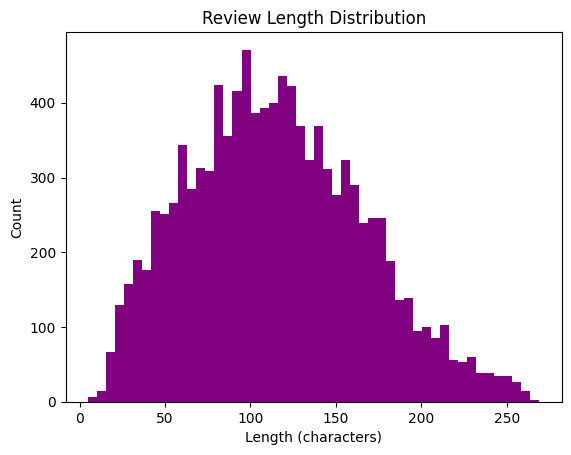

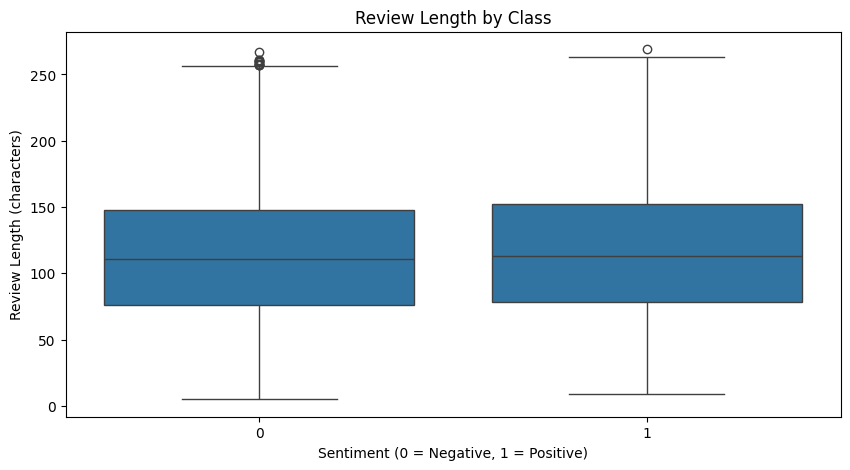

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kimin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


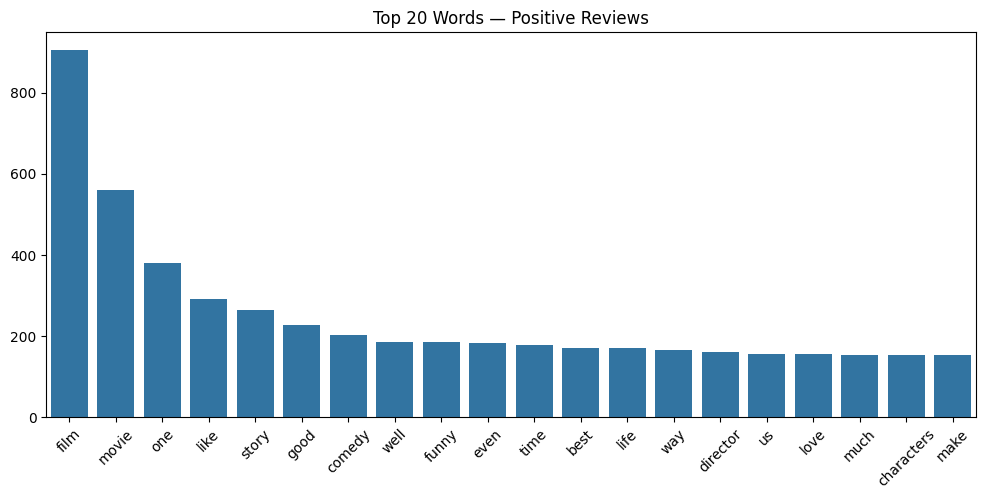

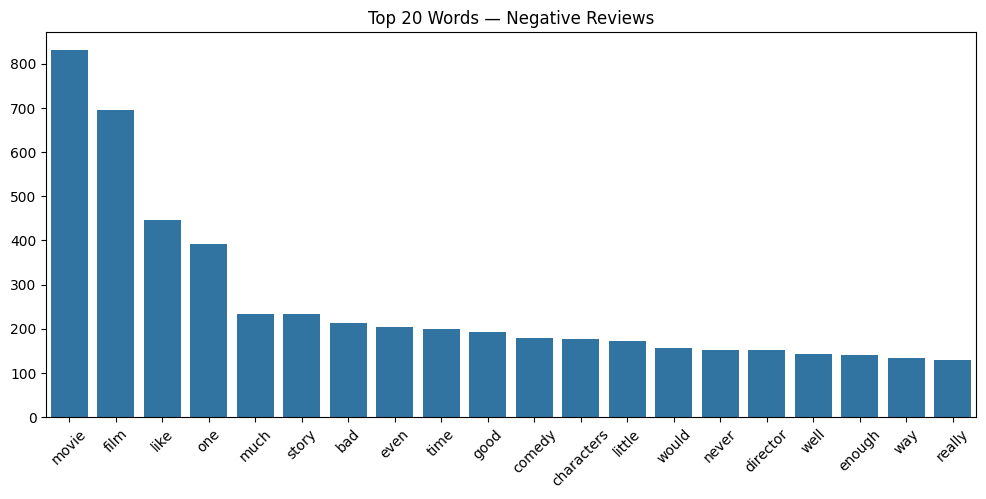

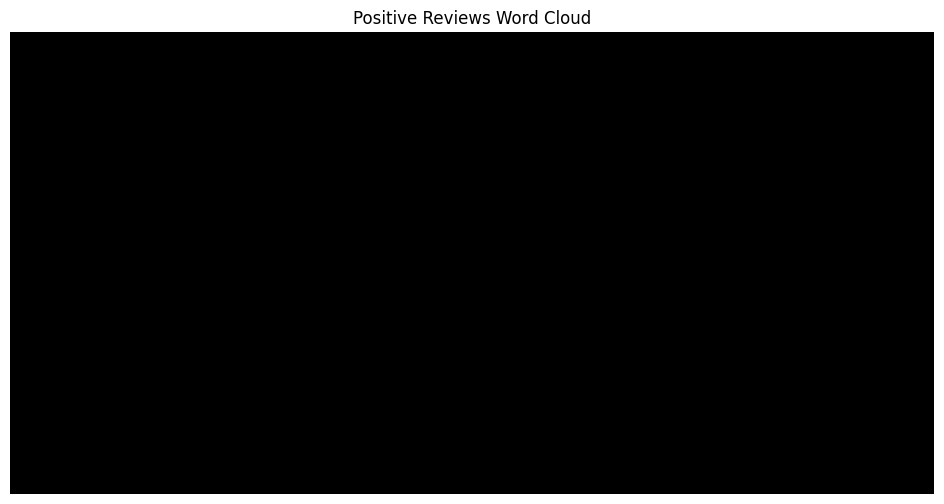

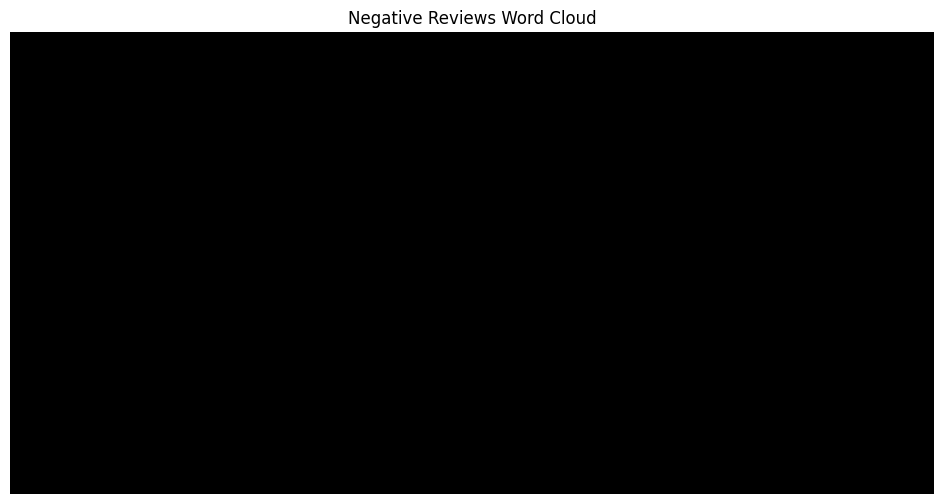

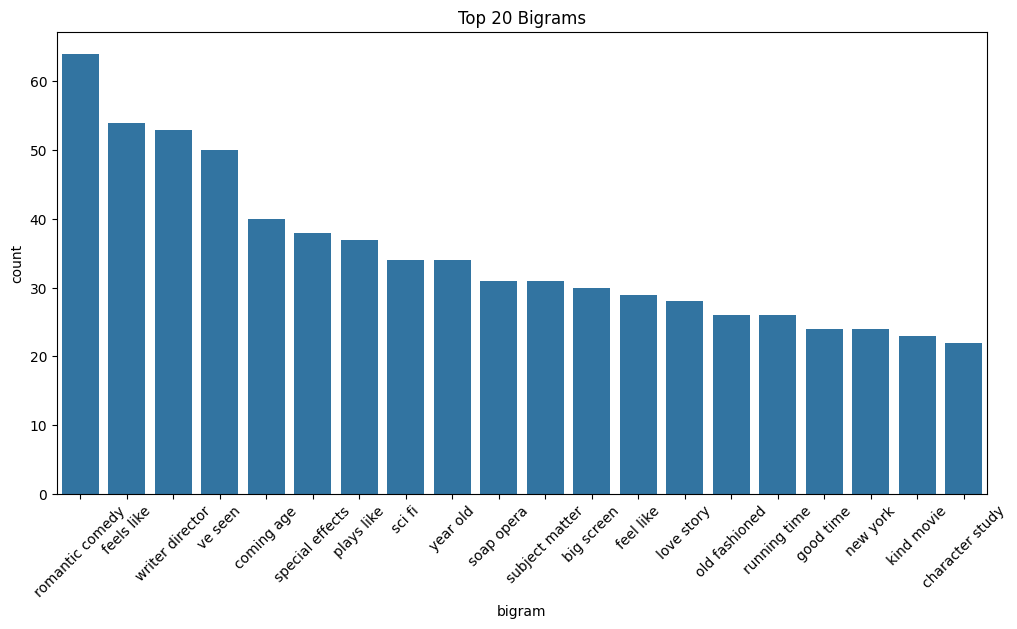

NameError: name 'gs' is not defined

In [3]:
# Class Distribution Plot

sns.countplot(data=df, x='labels')
plt.title("Class Distribution")
plt.show()


# Review Length Distribution

df['length'] = df['reviews'].str.len()

plt.hist(df['length'], bins=50, color='purple')
plt.title("Review Length Distribution")
plt.xlabel("Length (characters)")
plt.ylabel("Count")
plt.show()


# Review Length by Class

df['length'] = df['reviews'].str.len()

plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='labels', y='length')
plt.title("Review Length by Class")
plt.xlabel("Sentiment (0 = Negative, 1 = Positive)")
plt.ylabel("Review Length (characters)")
plt.show()


# Word Frequency by Class


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = set(stopwords.words("english"))

def clean_tokens(text):
    tokens = re.findall(r"\b\w+\b", text.lower())
    return [t for t in tokens if t not in stop]

df['clean_tokens'] = df['reviews'].apply(clean_tokens)

# -- Separate by class
pos_tokens = [w for tokens in df[df['labels']==1]['clean_tokens'] for w in tokens]
neg_tokens = [w for tokens in df[df['labels']==0]['clean_tokens'] for w in tokens]

from collections import Counter
pos_counts = Counter(pos_tokens).most_common(20)
neg_counts = Counter(neg_tokens).most_common(20)

plt.figure(figsize=(12,5))
sns.barplot(x=[w for w,c in pos_counts], y=[c for w,c in pos_counts])
plt.xticks(rotation=45)
plt.title("Top 20 Words — Positive Reviews")
plt.show()

plt.figure(figsize=(12,5))
sns.barplot(x=[w for w,c in neg_counts], y=[c for w,c in neg_counts])
plt.xticks(rotation=45)
plt.title("Top 20 Words — Negative Reviews")
plt.show()


# Word Clouds

pos_text = " ".join([" ".join(tokens) for tokens in df[df['labels']==1]['clean_tokens']])
neg_text = " ".join([" ".join(tokens) for tokens in df[df['labels']==0]['clean_tokens']])

plt.figure(figsize=(12,6))
wc_pos = WordCloud(width=800, height=400, background_color="white").generate(pos_text)
plt.imshow(wc_pos); plt.axis("off")
plt.title("Positive Reviews Word Cloud")
plt.show()

plt.figure(figsize=(12,6))
wc_neg = WordCloud(width=800, height=400, background_color="white").generate(neg_text)
plt.imshow(wc_neg); plt.axis("off")
plt.title("Negative Reviews Word Cloud")
plt.show()


# Bigram Frequency

bigram_cv = CountVectorizer(ngram_range=(2,2), stop_words='english')
bigram_matrix = bigram_cv.fit_transform(df['reviews'])
bigram_counts = bigram_matrix.sum(axis=0).A1

bigram_freq = list(zip(bigram_cv.get_feature_names_out(), bigram_counts))
bigram_freq_sorted = sorted(bigram_freq, key=lambda x: x[1], reverse=True)[:20]

bigram_df = pd.DataFrame(bigram_freq_sorted, columns=['bigram','count'])

plt.figure(figsize=(12,6))
sns.barplot(data=bigram_df, x='bigram', y='count')
plt.xticks(rotation=45)
plt.title("Top 20 Bigrams")
plt.show()


# TF-IDF Feature Importance

best_model = gs.best_estimator_
tfidf = best_model.named_steps['tfidf']
clf = best_model.named_steps['clf']

feature_names = np.array(tfidf.get_feature_names_out())
coeffs = clf.coef_[0]

# -- Top positive words
top_pos_idx = np.argsort(coeffs)[-20:]
top_pos = feature_names[top_pos_idx]
top_pos_coeffs = coeffs[top_pos_idx]

# -- Top negative words
top_neg_idx = np.argsort(coeffs)[:20]
top_neg = feature_names[top_neg_idx]
top_neg_coeffs = coeffs[top_neg_idx]

print("Top Positive Features:")
print(pd.DataFrame({"Word": top_pos, "Weight": top_pos_coeffs}))

print("\nTop Negative Features:")
print(pd.DataFrame({"Word": top_neg, "Weight": top_neg_coeffs}))


# Misclassification Analysis

y_pred = best_clf.predict(X_test)

test_df = pd.DataFrame({
    "review": X_test,
    "true": y_test,
    "pred": y_pred,
    "length": X_test.str.len()
})

# -- Incorrect predictions
wrong = test_df[test_df['true'] != test_df['pred']]

plt.figure(figsize=(8,5))
sns.histplot(wrong['length'], bins=40, color='red', kde=False)
plt.title("Length Distribution of Misclassified Reviews")
plt.show()


# Sentiment vs Review Length Quantiles

df['length_quantile'] = pd.qcut(df['length'], 10, labels=False)

plt.figure(figsize=(10,5))
sns.barplot(data=df, x='length_quantile', y='labels')
plt.title("Proportion of Positive Reviews by Length Quantile")
plt.xlabel("Length Quantile (0 = shortest, 9 = longest)")
plt.ylabel("Mean Sentiment (1 = positive)")
plt.show()


# Punctuation: Exclamation Marks

df['exclam'] = df['reviews'].str.count('!')

plt.figure(figsize=(10,5))
sns.histplot(df['exclam'], bins=20, color='orange')
plt.title("Exclamation Mark Distribution")
plt.xlabel("# of Exclamation Marks")
plt.show()



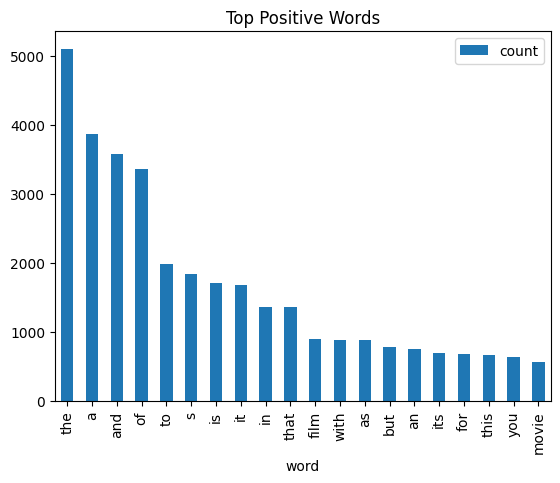

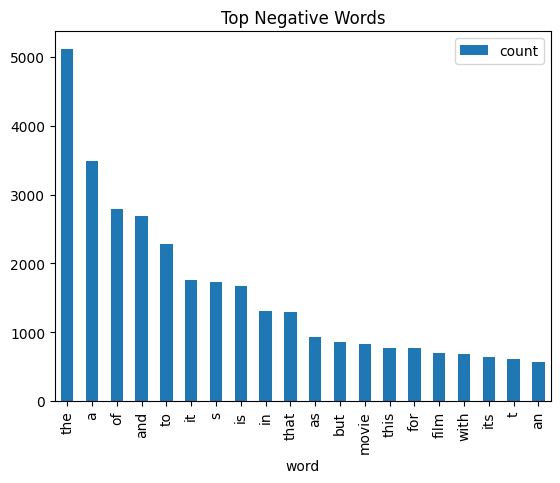

In [4]:
# Helper: simple tokenization
def tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())

df['tokens'] = df['reviews'].apply(tokenize)

# Separate by label
pos_tokens = [word for tokens in df[df['labels']==1]['tokens'] for word in tokens]
neg_tokens = [word for tokens in df[df['labels']==0]['tokens'] for word in tokens]

from collections import Counter

pos_counts = Counter(pos_tokens).most_common(20)
neg_counts = Counter(neg_tokens).most_common(20)

# Plot positive words
pd.DataFrame(pos_counts, columns=['word','count']).plot(kind='bar', x='word', y='count', title="Top Positive Words")
plt.show()

# Plot negative words
pd.DataFrame(neg_counts, columns=['word','count']).plot(kind='bar', x='word', y='count', title="Top Negative Words")
plt.show()


## Training and Testing Split

In [5]:
X = df['reviews']
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

len(X_train), len(X_test)


(8529, 2133)

## Machine Learning Pipeline

In [6]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

params_grid = [
    # Logistic Regression Grid
    {
        'tfidf__ngram_range': [(1,1),(1,2)],
        'tfidf__min_df': [1,2],
        'tfidf__max_df': [0.9,1.0],
        'clf': [LogisticRegression(max_iter=1000)],
        'clf__C': [0.1,1,10],
        'clf__class_weight': [None,'balanced']
    },

    # SVM Grid
    {
        'tfidf__ngram_range': [(1,1),(1,2)],
        'tfidf__min_df': [1,2],
        'tfidf__max_df': [0.9,1.0],
        'clf': [LinearSVC()],
        'clf__C': [0.1,1,10],
    },

    # XGBoost Grid
    {
        'tfidf__ngram_range': [(1,1),(1,2)],
        'tfidf__min_df': [1,2],
        'tfidf__max_df': [0.9,1.0],
        'clf': [XGBClassifier(eval_metric='logloss')],
        'clf__max_depth': [3,5],
        'clf__gamma': [0,0.25],
    }
]

gs = GridSearchCV(
    pipe,
    params_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

gs.fit(X_train, y_train)


Fitting 5 folds for each of 104 candidates, totalling 520 fits


,estimator,Pipeline(step..._iter=1000))])
,param_grid,"[{'clf': [LogisticRegre...max_iter=1000)], 'clf__C': [0.1, 1, ...], 'clf__class_weight': [None, 'balanced'], 'tfidf__max_df': [0.9, 1.0], ...}, {'clf': [LinearSVC()], 'clf__C': [0.1, 1, ...], 'tfidf__max_df': [0.9, 1.0], 'tfidf__min_df': [1, 2], ...}, ...]"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


## Evaluating Machine Learning Models

Best params: {'clf': LinearSVC(), 'clf__C': 1, 'tfidf__max_df': 0.9, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Accuracy: 0.7744960150023441
F1 Score: 0.7757575757575758

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.77      0.77      1062
           1       0.77      0.78      0.78      1071

    accuracy                           0.77      2133
   macro avg       0.77      0.77      0.77      2133
weighted avg       0.77      0.77      0.77      2133



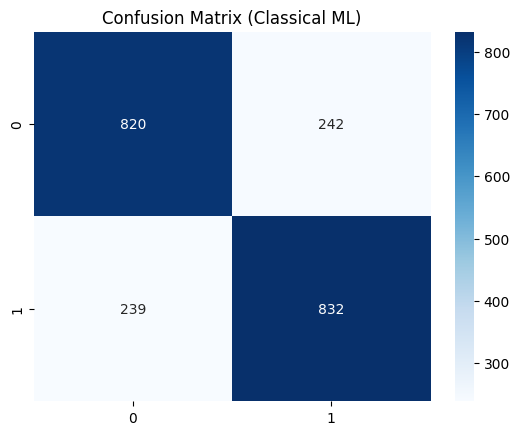

In [7]:
best_clf = gs.best_estimator_
y_pred_test = best_clf.predict(X_test)

print("Best params:", gs.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("F1 Score:", f1_score(y_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Classical ML)")
plt.show()


## Tokenizer for DistilBERT

In [13]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Encode training data
train_encodings = tokenizer(
    X_train.tolist(),
    truncation=True,
    padding=True,
    max_length=256
)

# Encode test data
test_encodings = tokenizer(
    X_test.tolist(),
    truncation=True,
    padding=True,
    max_length=256
)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

## PyTorch Dataset Generation

In [ ]:
class RTDataset(Dataset):
    """
    Custom dataset wrapping tokenized text + labels.
    Returns dictionaries compatible with DistilBERT.
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.values  # convert pandas Series to numpy array

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert tokenizer outputs to tensors + add label
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item


## Dataloaders Setup

In [ ]:
train_dataset = RTDataset(train_encodings, y_train)
test_dataset  = RTDataset(test_encodings, y_test)

# DataLoader provides batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

len(train_loader), len(test_loader)


(534, 134)

## Load DistilBERT Model

In [19]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2  # binary classification
).to(device)

model


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## Optimizer

In [20]:
# AdamW is recommended for Transformer fine-tuning
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


## Training Loop

In [ ]:
epochs = 2  # can increase to 3 for better performance

model.train()

for epoch in range(epochs):
    total_loss = 0
    loop = tqdm(train_loader, leave=True)
    
    for batch in loop:
        # Move batch to GPU/CPU
        batch = {k: v.to(device) for k, v in batch.items()}
        
        optimizer.zero_grad()  # clear gradients
        
        # Forward pass through DistilBERT
        outputs = model(**batch)
        loss = outputs.loss
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Track loss
        total_loss += loss.item()
        
        # Progress bar info
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} - Average Loss: {total_loss / len(train_loader):.4f}")


  0%|          | 0/534 [00:00<?, ?it/s]

Epoch 1 - Average Loss: 0.4185


  0%|          | 0/534 [00:00<?, ?it/s]

Epoch 2 - Average Loss: 0.2201


## Evaluating DistilBERT

DistilBERT Accuracy: 0.8466947960618847
DistilBERT F1: 0.8500687757909215

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1062
           1       0.84      0.87      0.85      1071

    accuracy                           0.85      2133
   macro avg       0.85      0.85      0.85      2133
weighted avg       0.85      0.85      0.85      2133



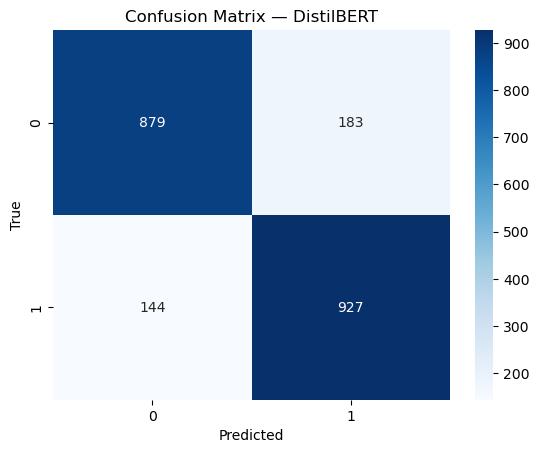

In [31]:
# ============================
# Evaluation — DistilBERT
# ============================

model.eval()

bert_preds = []        # <-- FIX: unique variable name
bert_true_labels = []  # <-- keep true labels separate too

with torch.no_grad():
    for batch in test_loader:
        labels = batch["labels"].numpy()
        bert_true_labels.extend(labels)

        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        # Predictions
        logits = outputs.logits
        bert_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())

# Metrics
print("DistilBERT Accuracy:", accuracy_score(bert_true_labels, bert_preds))
print("DistilBERT F1:", f1_score(bert_true_labels, bert_preds))
print("\nClassification Report:")
print(classification_report(bert_true_labels, bert_preds))

# Confusion Matrix
cm = confusion_matrix(bert_true_labels, bert_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix — DistilBERT")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## CNN Text Classifier

In [23]:
# Tokenize using word-level approach for CNN/LSTM
from collections import defaultdict

word2idx = {"<PAD>":0, "<UNK>":1}
idx2word = {0:"<PAD>", 1:"<UNK>"}

def build_vocab(texts, vocab_size=20000):
    freq = Counter()
    for t in texts:
        freq.update(tokenize(t))
    most_common = freq.most_common(vocab_size-2)
    for i,(w,_) in enumerate(most_common, start=2):
        word2idx[w] = i
    return word2idx

build_vocab(X_train)

def numericalize(text):
    return [word2idx.get(w,1) for w in tokenize(text)]

X_train_num = [torch.tensor(numericalize(t)) for t in X_train]
X_test_num = [torch.tensor(numericalize(t)) for t in X_test]

# Pad sequences
X_train_pad = pad_sequence(X_train_num, batch_first=True)
X_test_pad = pad_sequence(X_test_num, batch_first=True)

y_train_t = torch.tensor(y_train.values)
y_test_t = torch.tensor(y_test.values)

# Dataset
class CNN_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dl = DataLoader(CNN_Dataset(X_train_pad, y_train_t), batch_size=32, shuffle=True)
test_dl = DataLoader(CNN_Dataset(X_test_pad, y_test_t), batch_size=32)

# CNN Model
class CNN_Text(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.conv = nn.Conv1d(embed_dim, 128, kernel_size=5)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        emb = self.embedding(x).permute(0,2,1)
        c = self.conv(emb)
        p = self.pool(torch.relu(c)).squeeze(-1)
        out = self.fc(p)
        return out

cnn_model = CNN_Text(len(word2idx)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)

# Training loop
cnn_train_loss = []
cnn_test_loss = []

for epoch in range(3):
    cnn_model.train()
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = cnn_model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    cnn_train_loss.append(total_loss)

    # Validation
    cnn_model.eval()
    total_loss = 0
    for xb, yb in test_dl:
        xb, yb = xb.to(device), yb.to(device)
        pred = cnn_model(xb)
        loss = criterion(pred, yb)
        total_loss += loss.item()
    cnn_test_loss.append(total_loss)

    print(f"Epoch {epoch+1}: Train Loss={cnn_train_loss[-1]} Val Loss={cnn_test_loss[-1]}")


Epoch 1: Train Loss=178.81147420406342 Val Loss=41.42597597837448
Epoch 2: Train Loss=123.79190173745155 Val Loss=40.63717436790466
Epoch 3: Train Loss=60.73142334073782 Val Loss=42.120184272527695


## Evaluating CNN

CNN Accuracy: 0.6812001875293014
CNN F1: 0.6911898274296094

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.65      0.67      1062
           1       0.67      0.71      0.69      1071

    accuracy                           0.68      2133
   macro avg       0.68      0.68      0.68      2133
weighted avg       0.68      0.68      0.68      2133



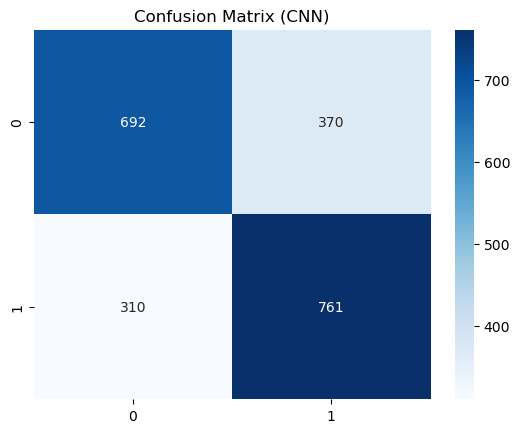

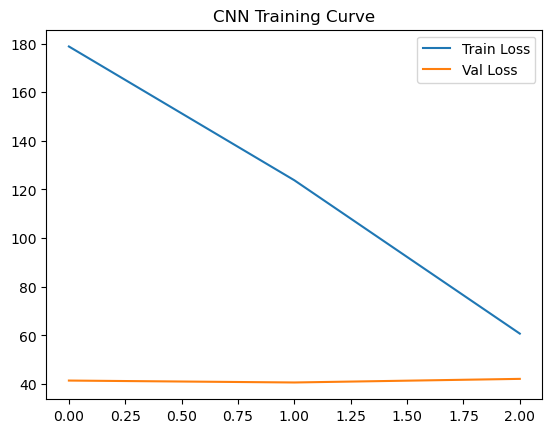

In [29]:
cnn_model.eval()
cnn_preds = []

for xb, yb in test_dl:
    xb = xb.to(device)
    with torch.no_grad():
        logits = cnn_model(xb)
    cnn_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())   # <-- FIXED

# Metrics
print("CNN Accuracy:", accuracy_score(y_test, cnn_preds))
print("CNN F1:", f1_score(y_test, cnn_preds))
print("\nClassification Report:\n", classification_report(y_test, cnn_preds))

# Confusion Matrix
cm = confusion_matrix(y_test, cnn_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (CNN)")
plt.show()

# Training Curves
plt.plot(cnn_train_loss, label="Train Loss")
plt.plot(cnn_test_loss, label="Val Loss")
plt.legend()
plt.title("CNN Training Curve")
plt.show()


## LSTM Text Classifier

In [25]:
class LSTM_Text(nn.Module):
    def __init__(self, vocab_size, embed_dim=100, hidden_dim=128, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        emb = self.embedding(x)
        out, (h, c) = self.lstm(emb)
        return self.fc(h[-1])

lstm_model = LSTM_Text(len(word2idx)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

lstm_train_loss = []
lstm_test_loss = []

for epoch in range(3):
    lstm_model.train()
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = lstm_model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    lstm_train_loss.append(total_loss)

    lstm_model.eval()
    total_loss = 0
    for xb, yb in test_dl:
        xb, yb = xb.to(device), yb.to(device)
        with torch.no_grad():
            pred = lstm_model(xb)
        loss = criterion(pred, yb)
        total_loss += loss.item()
    lstm_test_loss.append(total_loss)

    print(f"Epoch {epoch+1}: Train Loss={lstm_train_loss[-1]} Val Loss={lstm_test_loss[-1]}")


Epoch 1: Train Loss=185.12806457281113 Val Loss=46.463041841983795
Epoch 2: Train Loss=185.1455256342888 Val Loss=46.44685631990433
Epoch 3: Train Loss=185.22703349590302 Val Loss=46.444371700286865


## Evaluating LSTM

LSTM Accuracy: 0.49835911861228316
LSTM F1: 0.0018656716417910447

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.66      1062
           1       1.00      0.00      0.00      1071

    accuracy                           0.50      2133
   macro avg       0.75      0.50      0.33      2133
weighted avg       0.75      0.50      0.33      2133



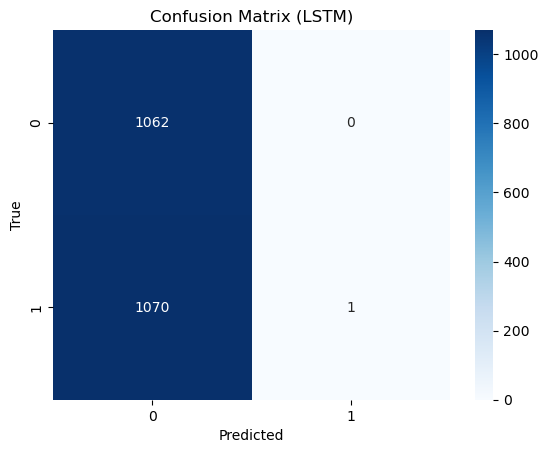

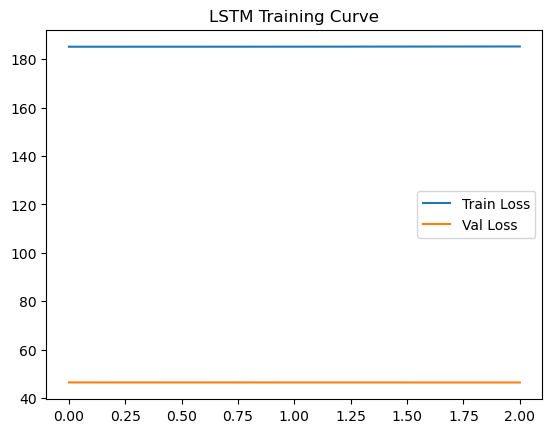

In [30]:
lstm_model.eval()
lstm_preds = []   # <-- FIX: use a unique variable name

for xb, yb in test_dl:
    xb = xb.to(device)
    with torch.no_grad():
        logits = lstm_model(xb)
    lstm_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())   # <-- FIXED

# Metrics
print("LSTM Accuracy:", accuracy_score(y_test, lstm_preds))
print("LSTM F1:", f1_score(y_test, lstm_preds))
print("\nClassification Report:\n", classification_report(y_test, lstm_preds))


# Confusion Matrix
cm = confusion_matrix(y_test, lstm_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (LSTM)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Training Curve
plt.plot(lstm_train_loss, label="Train Loss")
plt.plot(lstm_test_loss, label="Val Loss")
plt.legend()
plt.title("LSTM Training Curve")
plt.show()


## Comparison of Models

In [32]:
final_results = pd.DataFrame({
    'Model': [
        'TF-IDF + Best Classical',
        'CNN',
        'LSTM',
        'DistilBERT'
    ],
    
    'Accuracy': [
        accuracy_score(y_test, y_pred_test),          # Classical ML
        accuracy_score(y_test, cnn_preds),            # CNN
        accuracy_score(y_test, lstm_preds),           # LSTM
        accuracy_score(bert_true_labels, bert_preds)  # DistilBERT
    ],
    
    'F1 Score': [
        f1_score(y_test, y_pred_test),                # Classical ML
        f1_score(y_test, cnn_preds),                  # CNN
        f1_score(y_test, lstm_preds),                 # LSTM
        f1_score(bert_true_labels, bert_preds)        # DistilBERT
    ]
})

final_results


,Model,Accuracy,F1 Score
0,TF-IDF + Best Classical,0.774496,0.775758
1,CNN,0.681200,0.691190
2,LSTM,0.498359,0.001866
3,DistilBERT,0.846695,0.850069
